Universidad de Costa Rica  <br>
CI-0148 Aprendizaje Máquina <br>
Período: 2022-I <br>
Docente: Pablo Sauma Chacón <br>
Estudiante: 

- Jose Pablo Mora Villalobos. B85326
***

# Laboratorio 5

Objetivo: Familiarizar al estudiante con la creación y el uso de redes neuronales utilizando la biblioteca Torch. Así como la construcción de redes neuronales sofisticadas, como es el caso de una red convolucional para clasificación de imágenes.

[Descripción del laboratorio](https://docs.google.com/document/d/1zComHOY6E9vZ3ZtRXHEZ4IjLXoGxHVFOaMFwGlDWNrs/edit)

## 1.Importación de librerías y funciones auxiliares

En esta sección se importan las librerías que se utilizaran, y ademas se crean funciones para importar las imágenes en forma de tensores y para graficarlas en consola. 

Por último, se carga los datasets de pruebas y de entrenamiento.

Mounted at /content/drive


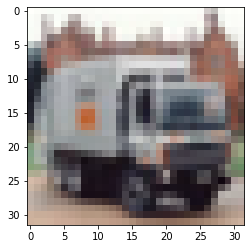

In [ ]:
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch as pt
import time
import random

# Usar solo si se trabaja desde google colab
from google.colab import drive
drive.mount('/content/drive');

# Custom subdirectory to find images
DIRECTORY = "drive/Othercomputers/My Computer/UCR/2022 I/Machine Learning/Labs/Lab 5/images"
# DIRECTORY = 'images' # Usar esta dirección cuando se trabaje a nivel local y no en google colab 

# Cargar las imágenes en dataset de entrenamiento y de pruebas 
def load_data():
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    names = [n.decode('utf-8') for n in unpickle(DIRECTORY+"/batches.meta")[b'label_names']]
    x_train = None
    y_train = []
    for i in range(1,6):
        data = unpickle(DIRECTORY+"/data_batch_"+str(i))
        if i>1:
            x_train = np.append(x_train, data[b'data'], axis=0)
        else:
            x_train = data[b'data']
        y_train += data[b'labels']
    data = unpickle(DIRECTORY+"/test_batch")
    x_test = data[b'data']
    y_test = data[b'labels']
    return names,x_train,y_train,x_test,y_test

# Imprimir la imagen
def plot_tensor(tensor, perm=None):
    if perm==None: perm = (1,2,0)
    plt.figure()
    plt.imshow(tensor.permute(perm).numpy().astype(np.uint8))
    plt.show()

names,x_train,y_train,x_test,y_test = load_data()
y_train = pt.tensor(y_train)
x_train = pt.tensor(x_train.reshape((50000,3,32,32)))
y_test= pt.tensor(y_test)
x_test = pt.tensor(x_test.reshape((10000,3,32,32)))

plot_tensor(x_test[random.randint(0,x_test.shape[0])])


## 2. Arquitectura de la red neuronal

Para crear la red se utiliza una clase llamada `ConvNN()`. La arquitectura de la red consiste en 3 capas convolucionales y una capa densa. Las capas convolucionales aumentan los canales de los datos de 3 a 13, pero reducen las dimensiones de cada canal a 2x2, con ayuda del funciones de `pooling`. Las dimensiones de los datos luego de pasar por las capas convolucionales es de 13x2x2. La última capa densa reduce estos datos hasta a solo 10. 

In [ ]:
class ConvNN(pt.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = pt.nn.Conv2d(3, 5, (5,5))
        self.fc2 = pt.nn.Conv2d(5, 7, (3,3))
        self.fc3 = pt.nn.Conv2d(7, 13, (3,3))
        self.fc4 = pt.nn.Linear(52, 10)
    
    def forward(self, x):
        h = pt.nn.LeakyReLU()(self.fc1(x))
        h = pt.nn.AvgPool2d(2)(h)
        h = pt.nn.LeakyReLU()(self.fc2(h))
        h = pt.nn.MaxPool2d(2)(h)
        h = pt.nn.LeakyReLU()(self.fc3(h))
        h = pt.nn.MaxPool2d(2)(h)
        h = h.view([h.shape[0],52])
        h = pt.nn.Tanh()(self.fc4(h))


        return h

## 3. Entrenamiento de la red

El entrenamiento de la red se hace con la función de perdida `CrossEntropyLoss()`, para calcular la probabilidad de que un dato sea de una categoría específica. El optimizador es Adam, con un *learning rate* de 0.006. En total se hicieron 250 iteraciones.

In [ ]:
# En caso de contar con tarjeta gráfica, guardar lo datos que se van a 
# usar en la gpu
device = pt.device('cuda' if pt.cuda.is_available() else 'cpu')
x_train, y_train, x_test, y_test = x_train.to(device), y_train.to(device), x_test.to(device), y_test.to(device)


model = ConvNN().to(device)		                            # Crea el modelo
loss_fn = pt.nn.CrossEntropyLoss()		                    # Función de error a utilizar
optimizer = pt.optim.Adam(model.parameters(), lr=0.006)   # Optimizador

# Creación de arreglos para guardar errores
loss_train = []
loss_test = []

x_train = x_train/255
x_test = x_test/255
size = x_train.shape[0]
batch_size = 2500

# Inicio del tiemp de entrenamiento
start = time.process_time() 
for i in range(250):
	# Entrenamiento por baches
	for j in range(size//batch_size):
		optimizer.zero_grad()				                                # Coloca los Δw en 0
		y_pred = model(x_train[batch_size*j:batch_size*(j+1)])		        # Predice los valores del conjunto de entrenamiento
		loss = loss_fn(y_pred, y_train[batch_size*j:batch_size*(j+1)])		# Calcula la pérdida
		loss.backward()				    	                                # Calcula el backprogration (Δw) y acumula el error
		optimizer.step()					                                # Aplica los Δw acumulados y avanza un paso la iter. 
	# Calcular los errores de los datos de prueba
	with pt.no_grad():			# Apaga el cálculo de gradientes
		y_pred1 = model(x_test)
		loss2 = loss_fn( y_pred1, y_test)
	loss_train.append(loss.item())
	loss_test.append(loss2.item())
	# Mostrar información de la época cada n itereaciones
	if ((i+1)%10==0):
		acc = pt.sum(pt.argmax(y_pred1,dim=1)==y_test)/y_test.shape[0]
		print("Epoch: {}, Loss: {:.5f}, Acc: {:.5f}, Time: {:.2f}".format(i+1, loss.item(), acc.item(), time.process_time() - start))			# Imprime la pérdida 


Epoch: 10, Loss: 1.76471, Acc: 0.41610, Time: 3.04
Epoch: 20, Loss: 1.66483, Acc: 0.44900, Time: 5.95
Epoch: 30, Loss: 1.62394, Acc: 0.46230, Time: 8.84
Epoch: 40, Loss: 1.59489, Acc: 0.47220, Time: 11.76
Epoch: 50, Loss: 1.58661, Acc: 0.48090, Time: 14.66
Epoch: 60, Loss: 1.57122, Acc: 0.48610, Time: 17.58
Epoch: 70, Loss: 1.56296, Acc: 0.49390, Time: 20.51
Epoch: 80, Loss: 1.56725, Acc: 0.49360, Time: 23.43
Epoch: 90, Loss: 1.55671, Acc: 0.49680, Time: 26.36
Epoch: 100, Loss: 1.55698, Acc: 0.50160, Time: 29.30
Epoch: 110, Loss: 1.54704, Acc: 0.49990, Time: 31.61
Epoch: 120, Loss: 1.54867, Acc: 0.49860, Time: 34.44
Epoch: 130, Loss: 1.54600, Acc: 0.49660, Time: 37.40
Epoch: 140, Loss: 1.55137, Acc: 0.50290, Time: 40.37
Epoch: 150, Loss: 1.55202, Acc: 0.50570, Time: 43.35
Epoch: 160, Loss: 1.54442, Acc: 0.50670, Time: 46.34
Epoch: 170, Loss: 1.54719, Acc: 0.51030, Time: 49.32
Epoch: 180, Loss: 1.53873, Acc: 0.51120, Time: 52.31
Epoch: 190, Loss: 1.54458, Acc: 0.51350, Time: 55.31
Epoch

Después de las 250 iteraciones, el resultado de la precisión del modelo fue de 51.38%, sin embargo se alcanzaron valores similares desde la iteración 180; incluso se alcanzo el 50% en la iteración 100.

## 4. Graficación de métricas de rendimiento.

Primero se muestra el error obtenido por cada iteración tanto para los valores de prueba como para los de entrenamiento. Después se calcula la matriz de confusión para identificar los valores en los que las predicciones no correspondieron con los valores reales. 

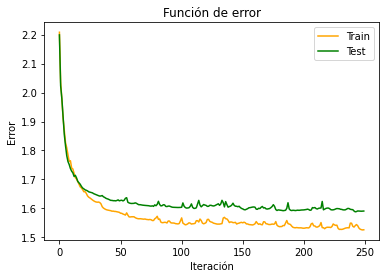

In [ ]:
plt.plot(loss_train, label='Train', c='orange')
plt.plot(loss_test, label='Test', c='g')
plt.title('Función de error')
plt.xlabel('Iteración')
plt.ylabel('Error')
plt.legend()
plt.show()

El gráfico anterior muestra que no se lograron reducciones del error relevantes desde la cerca de la iteración 75. También se muestra un poco el sesgo que tiene el modelo para determinar las categorías del conjunto de datos de entrenamiento.

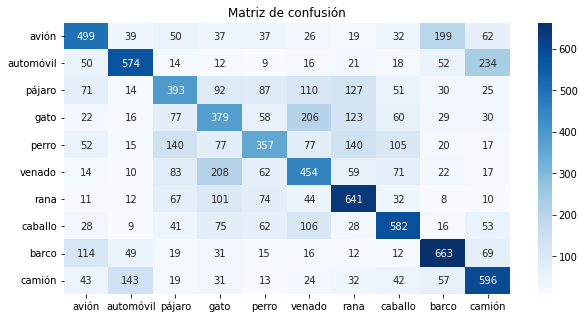

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

labels = ['avión', 'automóvil', 'pájaro', 'gato', 'perro', 'venado', 'rana', 'caballo', 'barco', 'camión']
CM = confusion_matrix(y_test.cpu(), pt.argmax(y_pred1.cpu(),dim=1))

plt.figure(figsize = (10,5))
heat_map = sns.heatmap(CM, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión')
heat_map.set_yticklabels(labels, rotation=0);
heat_map.set_xticklabels(labels, rotation=0);

Con la matriz de confusión se observa que las categorías que más se le dificultaron al modelo fueron las de animales: pájaro, gato, perro y venado, pero en particular las primeras 3, de las cuales no se logró ni siquiera 400 aciertos para las 1000 muestras de cada uno. El caso del gato y el venado es interesante porque hubo más de 400 clasificaciones erróneas entre ambas. En general, al modelo realiza bastantes clasificaciones erróneas en cuanto a cuál animal es cuál, aunque la rana y el caballo sí tuvieron bastantes aciertos. 

Por último, otro caso particular es el los medios de transporte, en los cuales, aunque sí cuenta con bastantes aciertos existen algunos errores. Por ejemplo, el camión y el automóvil causaron algo de confusión para el modelo, o el barco y el avión.